# HOMEWORK 5 - BUILDING ENERGY
___
# Author: Arno Amabile

In [1]:
import geopandas as gp
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import statsmodels.formula.api as smf
s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
plt.rcParams.update(s)
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Import energy data
nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

In [3]:
# Import MapPLUTO
bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")

## 1 - Cleaning the data

In [4]:
# Create the function to test if a value is convertible to float
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

# Vectorize the function and apply it
vconv = np.vectorize(canconvert)
indx = vconv(nrg['Site EUI(kBtu/ft2)'])
indx2 = vconv(nrg['Reported Property Floor Area (Building(s)) (ft²)'])

In [5]:
# Convert the non-convertible values to NaN
nrg['Site EUI(kBtu/ft2)'][~indx]=float('NaN')
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx2]=float('NaN')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [6]:
# Change the name of a column to merge, then merge
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
bblnrgdata = pd.merge(bsize,nrg,on=['BBL'])

/usr/local/lib/python2.7/site-packages/pandas/core/index.py:1695: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target.values)
/usr/local/lib/python2.7/site-packages/pandas/core/index.py:1049: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


## 2 - Fitting the data with OLS

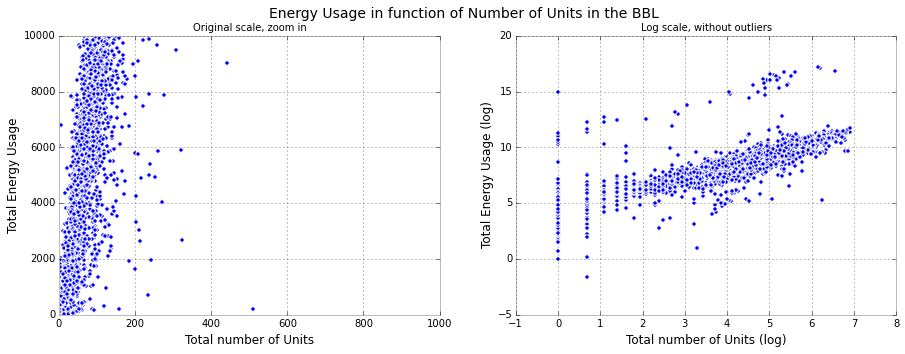

In [7]:
# Compute the variable Total Energy Usage Intensity
bblnrgdata['TotEUI'] = bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)*bblnrgdata.UnitsTotal


scatter = plt.figure(figsize=(15,5))

# Scatter plot with original scale, zoom in on a part of the plot
base = scatter.add_subplot(121)
plt.scatter(bblnrgdata['UnitsTotal'], bblnrgdata['TotEUI'])
plt.ylabel("Total Energy Usage")
plt.xlabel("Total number of Units")
plt.xlim(1,1000)
plt.ylim(1,10000)
plt.title("Original scale, zoom in", fontsize=10)

# Remove outliers
bblnrgdata_cut = bblnrgdata[(bblnrgdata.UnitsTotal>0) & (bblnrgdata.TotEUI>0) & (bblnrgdata.UnitsTotal<1000)]

# Scatter plot with a log scale, without outliers
cut = scatter.add_subplot(122)
plt.scatter(np.log(bblnrgdata_cut['UnitsTotal']), np.log(bblnrgdata_cut['TotEUI']))
plt.ylabel("Total Energy Usage (log)")
plt.xlabel("Total number of Units (log)")
plt.title("Log scale, without outliers", fontsize=10)

plt.suptitle('Energy Usage in function of Number of Units in the BBL', fontsize=14)

**Figure 1.** Total Energy Usage as a function of Total Number of Units for each BBL. The **left graph** is a zoom on the region where total number of units is non-null but less than 1000 and where the total energy usage is non-null but less than 10000. The **right graph** represents the same relationship on a log scale, after having removed the outliers.

                            OLS Regression Results                            
Dep. Variable:         np.log(TotEUI)   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                 1.592e+04
Date:                Sun, 18 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:24:36   Log-Likelihood:                -6338.2
No. Observations:                4985   AIC:                         1.268e+04
Df Residuals:                    4983   BIC:                         1.269e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              4.4961      0

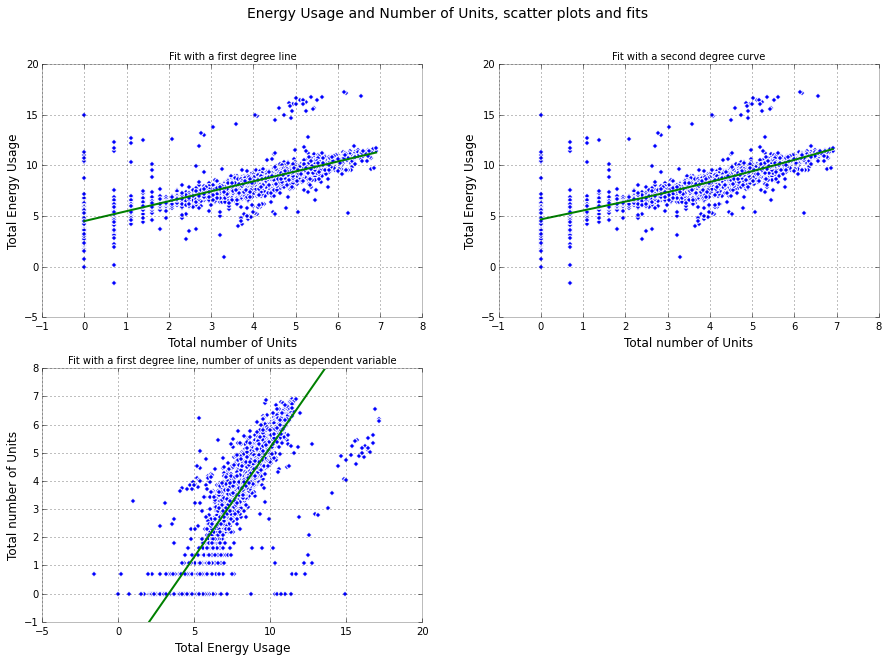

In [8]:
# Support for the line fits
x = pd.DataFrame({'UnitsTotal': np.linspace(bblnrgdata_cut.UnitsTotal.min(),
                                            bblnrgdata_cut.UnitsTotal.max(), 100)})
x2 = pd.DataFrame({'TotEUI': np.linspace(bblnrgdata_cut.TotEUI.min(),
                                            bblnrgdata_cut.TotEUI.max(), 100)})

fit = plt.figure(figsize=(15,10))
plt.suptitle("Energy Usage and Number of Units, scatter plots and fits", fontsize=14)

# Fit with a first degree line
bino = fit.add_subplot(221)
poly_1 = smf.ols(formula='np.log(TotEUI) ~ np.log(UnitsTotal)', data=bblnrgdata_cut).fit()
plt.scatter(np.log(bblnrgdata_cut['UnitsTotal']), np.log(bblnrgdata_cut['TotEUI']))
plt.plot(np.log(x), poly_1.predict(x), 'g-')
plt.ylabel("Total Energy Usage")
plt.xlabel("Total number of Units")
plt.title("Fit with a first degree line", fontsize=10)

# Fit with a second degree curve
poly = fit.add_subplot(222)
poly_2 = smf.ols(formula='np.log(TotEUI) ~ np.log(UnitsTotal) + I(np.log(UnitsTotal) ** 2.0)', 
                 data=bblnrgdata_cut).fit()
plt.scatter(np.log(bblnrgdata_cut['UnitsTotal']), np.log(bblnrgdata_cut['TotEUI']))
plt.plot(np.log(x), poly_2.predict(x), 'g-')
plt.ylabel("Total Energy Usage")
plt.xlabel("Total number of Units")
plt.title("Fit with a second degree curve", fontsize=10)

# Fit with a first degree line, axis reversed with Energy Usage as the independent variable
reverse = fit.add_subplot(223)
m, b = np.polyfit(np.log(bblnrgdata_cut['TotEUI']), np.log(bblnrgdata_cut['UnitsTotal']), 1)
plt.scatter(np.log(bblnrgdata_cut['TotEUI']), np.log(bblnrgdata_cut['UnitsTotal']))
plt.plot(np.log(x2), m*np.log(x2) + b, 'g-')
plt.xlabel("Total Energy Usage")
plt.ylabel("Total number of Units")
plt.ylim(-1,8)
plt.xlim(-5,20)
plt.title("Fit with a first degree line, number of units as dependent variable", fontsize=10)


print poly_1.summary()
print poly_2.summary()

**Figure 2.** The upper graphs represent the fit of energy usage as a function of number of units. The **left** one is a first-degree line fit, and the **right** one a second-degree curve fit. The bottom graph has reversed axis. Two conclusions: 

**(1)** The graph of total number of units as a function of total energy usage is not more readable and makes less sense, as the number of units is unlikely to be affected by the energy usage. A likelihood ratio test is useless here as the two models are not nested one in each other, and not really comparable.

**(2)** The second-degree curve does not seem to fit the data substantially better than the first-degree line. We can test this by doing a Likelihood-ratio test:

$ LR = 2 \times log \left( \frac{L(model_1}{L(model_2}\right) = 2 \times [log(L(model_1) - log(L(model_2)] = 2 \times (- 6338.2 - (-6313.4)) = - 49.6 $

With one degree of freedom (the polynomial model adds only one variable to the first model), the critical value for a significance level of 0.5 % in the $\chi^2$ distribution is 7.879. As LR is far smaller than this, we cannot reject the null hypothesis. The polynomial model does not fit the data significantly better than the first model.


## 3 - Fitting the data with WLS

In [9]:
W=[1]*len(bblnrgdata_cut.UnitsTotal)
for idx, val in enumerate(bblnrgdata_cut.UnitsTotal):
    if np.var(np.log(bblnrgdata_cut['TotEUI'])[bblnrgdata_cut['UnitsTotal'] == val]) != 0:
        W[idx] = 1. / np.var(np.log(bblnrgdata_cut['TotEUI'])[bblnrgdata_cut['UnitsTotal'] == val])**2
    else:
        W[idx] = 1

                            WLS Regression Results                            
Dep. Variable:                 TotEUI   R-squared:                       0.817
Model:                            WLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                 2.224e+04
Date:                Sun, 18 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:24:45   Log-Likelihood:                -23476.
No. Observations:                4985   AIC:                         4.696e+04
Df Residuals:                    4983   BIC:                         4.697e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.7363      0.049     76.541      0.0

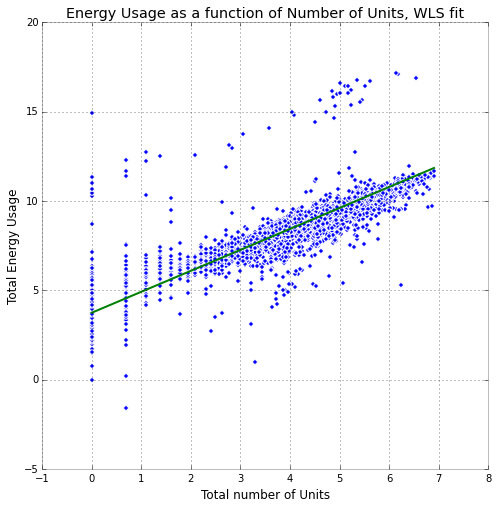

In [10]:
mod_wls = sm.WLS(np.log(bblnrgdata_cut['TotEUI']), sm.add_constant(np.log(bblnrgdata_cut['UnitsTotal'])),
                 weights=W).fit()

plt.figure(figsize=(8,8))
plt.scatter(np.log(bblnrgdata_cut['UnitsTotal']), np.log(bblnrgdata_cut['TotEUI']))
plt.plot(np.log(x), mod_wls.params[0] + np.log(x)*mod_wls.params[1], 'g-')
plt.ylabel("Total Energy Usage")
plt.xlabel("Total number of Units")
plt.title("Energy Usage as a function of Number of Units, WLS fit")
print mod_wls.summary()

**Figure 3.** Total Energy Usage as a function of Total Number of Units, fitted with a weighted least square. As explained in the documentation, if the weight provided is $\frac{1}{W}$, the variables will be pre-multiplied by $\frac{1}{\sqrt{W}}$. As I want to weight them by $\frac{1}{\sigma^2}$, I inputed the weight $\frac{1}{Var^2}$

Source: http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.WLS.html}

## 4 - SSR heat map

In [11]:
y = np.log(bblnrgdata_cut['TotEUI'])
x = np.log(bblnrgdata_cut['UnitsTotal'])

# Define function compute the sum of square residuals
def res(a,b):
    return sum((y - x*a - b)**2)

A = np.arange(-50.,50.,0.5)
B = np.arange(-100,100,1)
Lsurface=[[1]*len(A)]*len(B)
vres = np.vectorize(res)

# Partial vectorization of the process
for idx, a in enumerate(A):
    Lsurface[idx] = vres(a,B)

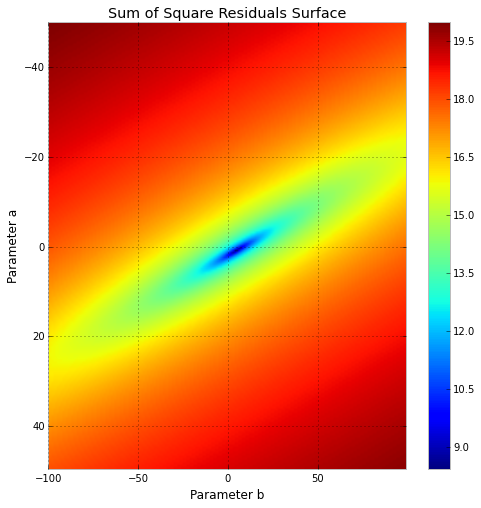

In [12]:
plt.figure(figsize=(8,8))
plt.ylabel("Parameter a")
plt.xlabel("Parameter b")
plt.imshow(Lsurface)
plt.imshow(np.log(Lsurface), aspect='auto',extent=[B.min(),B.max(),A.max(),A.min()])
plt.colorbar()
plt.title("Sum of Square Residuals Surface")

**Figure 4.** Heat map of the sum of square residuals for each combination of parameters in the sets A and B. The minimum SSR appears to be around our ols estimate of $(a,b)=(0.9793,4.4961)$.

## 5 - Let's get creative!

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/pandas/core/generic.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python2.7/site-packages/ipykernel/__

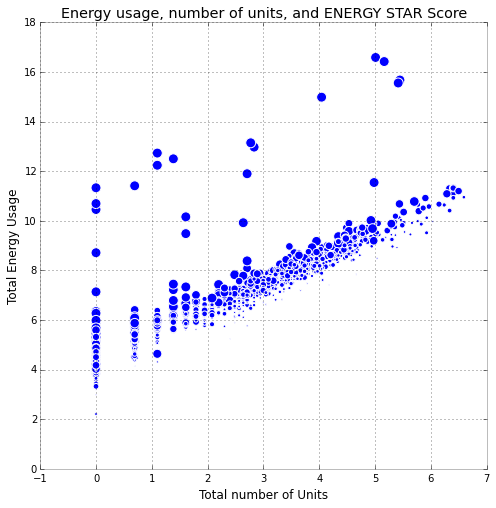

In [13]:
# I compute the energy usage as a function of number of units, with points proportionnal 
# to their distance to the perfect ENERGY STAR Score

indx3 = vconv(bblnrgdata_cut['ENERGY STAR Score'])
bblnrgdata_cut['ENERGY STAR Score'][~indx3]=float('NaN')

bblnrgdata_cut['ESTAR'] = bblnrgdata_cut['ENERGY STAR Score'].astype(float)

plt.figure(figsize=(8,8))
plt.ylabel("Total Energy Usage")
plt.xlabel("Total number of Units")
plt.scatter(np.log(bblnrgdata_cut['UnitsTotal']), np.log(bblnrgdata_cut['TotEUI']),
            s=100 - bblnrgdata_cut['ESTAR'])
plt.title("Energy usage, number of units, and ENERGY STAR Score")

**Figure 5.** Total Energy Usage as a function of Number of Units. Each point is proportional to the distance of the unit score to the perfect ENERGY STAR Score. It seems that for a given number of units, units with a higher energy usage are farther away from the perfect ENERGY STAR score. This is reassuring... But this is not enough to conclude on the pertinence of ENERGY STAR Scores!